<h1 style="font-size:50px;">Exploratory Data Analysis</h1>

### Import Modules

In [3]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import unicodedata
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import wordcloud

import spacy
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaMulticore
import pyLDAvis.gensim

nlp = spacy.load("en_core_web_sm")

#### General Functions

In [4]:
def casefolding(data):
    new_str = data.lower()
    return str(new_str)

In [5]:
def remove_non_ascii(data):
    data = unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return data

In [6]:
def remove_digits(data):
    data = re.sub("\d+", " ", data)
    return data

<>:2: DeprecationWarning: invalid escape sequence '\d'
<>:2: DeprecationWarning: invalid escape sequence '\d'
C:\Users\dmaka\AppData\Local\Temp\ipykernel_36508\2789525431.py:2: DeprecationWarning: invalid escape sequence '\d'
  data = re.sub("\d+", " ", data)


In [8]:
def remove_stopwords(data):
    stop_words =  set(stopwords.words('english'))
    word_tokens = word_tokenize(data)
    sent = [WordNetLemmatizer().lemmatize(w,'v') for w in word_tokens if w not in stop_words and len(w) > 1]
    return " ".join(sent)

In [11]:
def remove_spaces(data):
    data = re.sub(r'[\s]+', ' ', data)
    return data

In [13]:
def remove_hashtag(data):
    data = re.sub(r"#[^\s]+", "", data)
    return data

In [15]:
def remove_special(data):
    data = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", data)
    return data

In [16]:
def preprocess(data):
    # Convert to small case
    data = casefolding(data)
    
    # Remove Non-ASCII values
    data = remove_non_ascii(data)
    
    # Remove Digits
    data = remove_digits(data)
    
    # Remove Hashtag
    data = remove_hashtag(data)
    
    # Remove Special Characters
    data = remove_special(data)
    
    # Remove Stopwords
    data = remove_stopwords(data)
    
    # Remove additional white spaces
    data = remove_spaces(data)
    
    return data

In [17]:
def combine_data(df):
    new_df = df["Questions"] + " " + df["Answers"]
    return new_df

In [18]:
def prepare_lda(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

In [19]:
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

### Data Extraction

In [20]:
dataset = pd.read_csv("Data/intent_data.csv")

In [21]:
dataset

,Questions,Answers,Intent
0,It just feels like everything is falling apart...,It sounds like you're placing a lot of blame o...,Stress
1,"We've tried talking, but it always ends up esc...",It can be incredibly challenging when communic...,Stress
2,I haven't really thought about it. To be hones...,It's understandable that you may feel skeptica...,Stress
3,I guess it couldn't hurt to give it a try. But...,It's natural to have doubts and fears when fac...,Anxiety
4,I never thought that therapy could be helpful ...,"Absolutely, Charlie. Therapy is not just about...",Therapeutic Techniques
...,...,...,...
855670,I haven't thought about that yet. I'll look in...,"That's a great step, Charlie. Consulting a fin...",Stress
855671,"Thank you, Alex, for reminding me of that. It'...","It's understandable, Charlie. It's common for ...",Therapeutic Techniques
855672,"Well, I've been experiencing some physical sym...",It's important to note the mind and body conne...,Anxiety
855673,"I've been having frequent headaches, difficult...",I can imagine how distressing these physical s...,Anxiety


In [22]:
dataset.describe()

,Questions,Answers,Intent
count,855675,855675,855675
unique,789159,807013,14
top,"Is it normal for people to cry during therapy,...",This condition is inherited in an autosomal re...,Stress
freq,240,348,203857


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855675 entries, 0 to 855674
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Questions  855675 non-null  object
 1   Answers    855675 non-null  object
 2   Intent     855675 non-null  object
dtypes: object(3)
memory usage: 19.6+ MB


In [24]:
dataset.shape

(855675, 3)

### Data Cleaning

In [25]:
cleaned_dataset = dataset.copy()

In [26]:
cleaned_dataset

,Questions,Answers,Intent
0,It just feels like everything is falling apart...,It sounds like you're placing a lot of blame o...,Stress
1,"We've tried talking, but it always ends up esc...",It can be incredibly challenging when communic...,Stress
2,I haven't really thought about it. To be hones...,It's understandable that you may feel skeptica...,Stress
3,I guess it couldn't hurt to give it a try. But...,It's natural to have doubts and fears when fac...,Anxiety
4,I never thought that therapy could be helpful ...,"Absolutely, Charlie. Therapy is not just about...",Therapeutic Techniques
...,...,...,...
855670,I haven't thought about that yet. I'll look in...,"That's a great step, Charlie. Consulting a fin...",Stress
855671,"Thank you, Alex, for reminding me of that. It'...","It's understandable, Charlie. It's common for ...",Therapeutic Techniques
855672,"Well, I've been experiencing some physical sym...",It's important to note the mind and body conne...,Anxiety
855673,"I've been having frequent headaches, difficult...",I can imagine how distressing these physical s...,Anxiety


##### Check Null Values

In [27]:
dataset.isnull().sum()

Questions    0
Answers      0
Intent       0
dtype: int64

##### Remove Null Values

In [28]:
dataset.dropna(inplace=True)

In [29]:
dataset.isnull().sum()

Questions    0
Answers      0
Intent       0
dtype: int64

In [30]:
cleaned_dataset = cleaned_dataset.dropna().reset_index(drop = True)

##### Cleaning Dataframe

In [31]:
cleaned_dataset["Questions"] = cleaned_dataset["Questions"].apply(preprocess)

In [32]:
cleaned_dataset["Answers"] = cleaned_dataset["Answers"].apply(preprocess)

In [33]:
cleaned_dataset

,Questions,Answers,Intent
0,feel like everything fall apart partner argue ...,sound like place lot blame charlie important r...,Stress
1,try talk always end escalate heat argument lik...,incredibly challenge communication break confl...,Stress
2,really think honest feel overwhelm everything ...,understandable may feel skeptical effectivenes...,Stress
3,guess hurt give try work late us,natural doubt fear face challenge remember cha...,Anxiety
4,never think therapy could helpful even things ...,absolutely charlie therapy save relationships ...,Therapeutic Techniques
...,...,...,...
855670,think yet look find financial advisor guide pr...,great step charlie consult financial advisor p...,Stress
855671,thank alex remind easy forget seek help sign w...,understandable charlie common us think handle ...,Therapeutic Techniques
855672,well experience physical symptoms worry sure r...,important note mind body connection charlie ex...,Anxiety
855673,frequent headaches difficulty sleep occasional...,imagine distress physical symptoms must charli...,Anxiety


In [34]:
cleaned_dataset.isnull().sum()

Questions    0
Answers      0
Intent       0
dtype: int64

In [35]:
combined_dataset = combine_data(cleaned_dataset)

In [36]:
combined_dataset

0         feel like everything fall apart partner argue ...
1         try talk always end escalate heat argument lik...
2         really think honest feel overwhelm everything ...
3         guess hurt give try work late us natural doubt...
4         never think therapy could helpful even things ...
                                ...                        
855670    think yet look find financial advisor guide pr...
855671    thank alex remind easy forget seek help sign w...
855672    well experience physical symptoms worry sure r...
855673    frequent headaches difficulty sleep occasional...
855674    reach yet hop would go away persist guess time...
Length: 855675, dtype: object

In [37]:
questions = cleaned_dataset["Questions"].apply(lambda x: x.split())
answers = cleaned_dataset["Answers"].apply(lambda x: x.split())
corpus = []
for i in questions:
    for j in i:
        corpus.append(j)
for i in answers:
    for j in i:
        corpus.append(j)
corpus = " ".join(corpus)

### Data Visualization

In [38]:
eda_dataset = cleaned_dataset.copy()

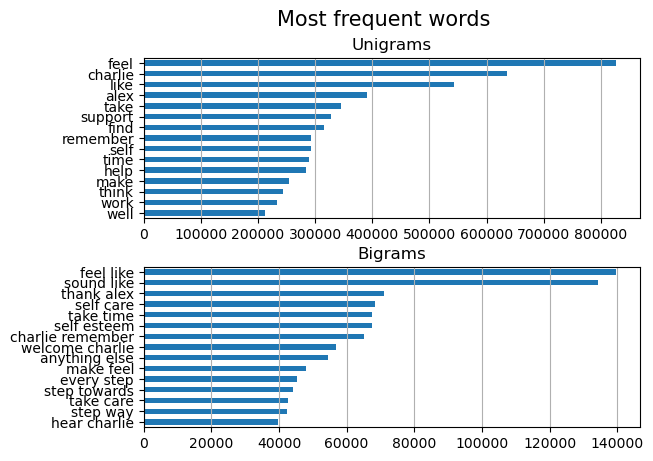

In [39]:
tokens_list = nltk.tokenize.word_tokenize(corpus)

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)

# Unigrams

word_freq_dict = nltk.FreqDist(tokens_list)
def_uni = pd.DataFrame(word_freq_dict.most_common(), columns=['Word','Freq'])
def_uni.set_index('Word').iloc[:15,:].sort_values(by='Freq').plot(kind='barh', title='Unigrams', ax=ax[0], legend=False).grid(axis='x')

# Bigrams

words_freq_dict2 = nltk.FreqDist(nltk.ngrams(tokens_list, 2))
bi_dtf = pd.DataFrame(words_freq_dict2.most_common(), columns=["Word","Freq"])
bi_dtf["Word"] = bi_dtf["Word"].apply(lambda x: " ".join(string for string in x) )
bi_dtf.set_index("Word").iloc[:15,:].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],legend=False).grid(axis='x')

ax[0].set(ylabel=None)
ax[1].set(ylabel=None)
plt.subplots_adjust(hspace=0.3)
plt.show()

c:\Users\dmaka\anaconda3\envs\Pytorch2.0\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


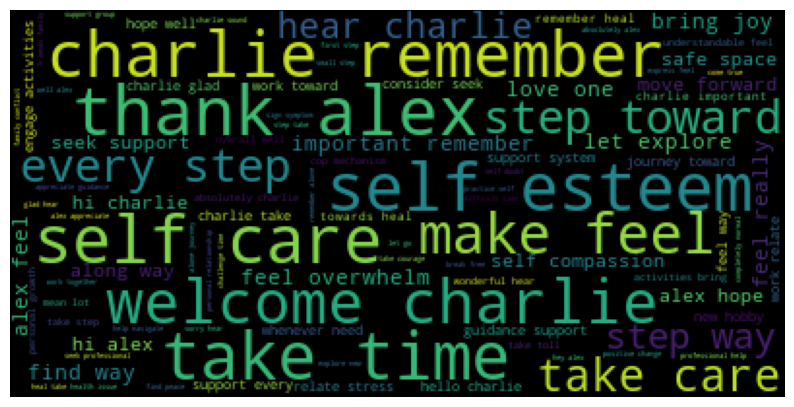

In [40]:
plt.figure(figsize=(10, 6))
wc = wordcloud.WordCloud(background_color='black', max_words=100, max_font_size=35)
wc = wc.generate(corpus)
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [ ]:
preprocessed_documents = [prepare_lda(doc) for doc in combined_dataset]

In [17]:
dictionary = Dictionary(preprocessed_documents)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_documents]

tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

In [18]:
num_topics = 10
lda_model = LdaMulticore(tfidf_corpus, id2word=dictionary, num_topics=num_topics, workers=14)

In [19]:
topics = lda_model.print_topics(num_topics=25)
for topic in topics:
    print(topic)

(0, '0.007*"conflict" + 0.007*"like" + 0.006*"family" + 0.006*"frequency" + 0.005*"feel" + 0.005*"relationship" + 0.005*"genetic" + 0.005*"parent" + 0.005*"sound" + 0.005*"disease"')
(1, '0.007*"emotion" + 0.007*"relationship" + 0.007*"trust" + 0.007*"feel" + 0.006*"grief" + 0.006*"lose" + 0.006*"pain" + 0.006*"loss" + 0.005*"fear" + 0.005*"love"')
(2, '0.011*"paint" + 0.011*"hobby" + 0.010*"new" + 0.010*"activity" + 0.008*"joy" + 0.008*"bring" + 0.006*"nature" + 0.006*"wonderful" + 0.006*"engage" + 0.006*"self"')
(3, '0.008*"care" + 0.008*"self" + 0.008*"set" + 0.007*"boundary" + 0.007*"prioritize" + 0.006*"dream" + 0.006*"work" + 0.006*"time" + 0.005*"balance" + 0.005*"small"')
(4, '0.008*"symptom" + 0.008*"anxiety" + 0.007*"stress" + 0.007*"work" + 0.006*"like" + 0.006*"pressure" + 0.006*"overwhelm" + 0.005*"feel" + 0.005*"trigger" + 0.005*"constantly"')
(5, '0.009*"communication" + 0.009*"conflict" + 0.009*"express" + 0.009*"conversation" + 0.008*"understand" + 0.008*"open" + 0.007

In [22]:
plot_lda_vis(lda_model, tfidf_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.110823  0.089946       1        1  14.746338
5      0.027522 -0.022949       2        1  11.522136
1      0.044090  0.042783       3        1  10.854512
2     -0.117712 -0.000923       4        1  10.594785
6      0.131384  0.095955       5        1   9.943023
7     -0.022210 -0.019096       6        1   9.323530
3     -0.084083 -0.042805       7        1   9.257819
4      0.087161 -0.078621       8        1   9.240335
8     -0.026652 -0.034830       9        1   8.815452
0      0.071324 -0.029460      10        1   5.702072, topic_info=           Term          Freq         Total Category  logprob  loglift
142          hi   8965.000000   8965.000000  Default  30.0000  30.0000
13         tell  11850.000000  11850.000000  Default  29.0000  29.0000
3        lately  10296.000000  10296.000000  Default  28.0000  28.0000
138     welcome   9194.000000   9194.000000  Default  27.0000  27.0000
449       paint   6250.000000   6250.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
41   constantly    683.594546   6327.892274  Topic10  -5.8559   0.6390
96         time    788.520595  17327.027659  Topic10  -5.7131  -0.2255
92        start    744.830719  12204.076422  Topic10  -5.7701   0.0680
38   understand    715.149494  15067.638500  Topic10  -5.8107  -0.1835
0     challenge    704.195004  13329.141256  Topic10  -5.8262  -0.0763

[977 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4625      1  0.006784  abnormal
4625      2  0.915841  abnormal
4625      4  0.013568  abnormal
4625      7  0.054272  abnormal
2299      1  0.017235  abruptly
...     ...       ...       ...
2757      6  0.004368    writer
2757      7  0.644973    writer
2757      8  0.018927    writer
2757      9  0.106282    writer
2757     10  0.014559    writer

[5018 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 2, 3, 7, 8, 4, 5, 9, 1])

In [134]:
len(preprocessed_documents)

855675

In [136]:
processed_data = pd.DataFrame.from_dict({"Data" : preprocessed_documents})
processed_data

,Data
0,"[feel, sad, overwhelm, lately, work, massive, ..."
1,"[recently, promotion, work, think, excite, add..."
2,"[workload, increase, significantly, find, hard..."
3,"[try, prioritize, task, delegate, possible, st..."
4,"[right, open, struggle, coworker, supervisor, ..."
...,...
855670,"[diabetic, neuropathy, nerve, damage, diabetes..."
855671,"[prevent, diabetic, neuropathy, nerve, damage,..."
855672,"[diagnose, diabetic, neuropathy, nerve, damage..."
855673,"[treatment, diabetic, neuropathy, nerve, damag..."


In [ ]:
processed_data.to_csv("processed_data.csv", index=False)

In [145]:
topic_dict = {}
for topic in topics:
    topic_index, words = topic
    topic_dict[int(topic_index)] = words

In [147]:
# Iterate through each document in the corpus
def get_topic(data):
    # Get the topic distribution for the document
    topic_distribution = lda_model.get_document_topics(dictionary.doc2bow(data), minimum_probability=0.0)

    # Find the topic with the highest probability
    highest_prob_topic = max(topic_distribution, key=lambda x: x[1])
    
    topic_words = topic_dict[highest_prob_topic[0]]
    
    return topic_words

In [149]:
all_data_topics = processed_data["Data"].apply(get_topic)

In [150]:
processed_data["Topic"] = all_data_topics

In [151]:
processed_data

,Data,Topic
0,"[feel, sad, overwhelm, lately, work, massive, ...","0.025*""tell"" + 0.025*""hi"" + 0.019*""lately"" + 0..."
1,"[recently, promotion, work, think, excite, add...","0.010*""stress"" + 0.009*""work"" + 0.009*""pressur..."
2,"[workload, increase, significantly, find, hard...","0.010*""stress"" + 0.009*""work"" + 0.009*""pressur..."
3,"[try, prioritize, task, delegate, possible, st...","0.019*""boundary"" + 0.010*""set"" + 0.009*""relati..."
4,"[right, open, struggle, coworker, supervisor, ...","0.016*""therapy"" + 0.011*""support"" + 0.011*""see..."
...,...,...
855670,"[diabetic, neuropathy, nerve, damage, diabetes...","0.010*""fear"" + 0.009*""disease"" + 0.006*""feel"" ..."
855671,"[prevent, diabetic, neuropathy, nerve, damage,...","0.010*""fear"" + 0.009*""disease"" + 0.006*""feel"" ..."
855672,"[diagnose, diabetic, neuropathy, nerve, damage...","0.013*""treatment"" + 0.012*""symptom"" + 0.011*""c..."
855673,"[treatment, diabetic, neuropathy, nerve, damag...","0.013*""treatment"" + 0.012*""symptom"" + 0.011*""c..."


In [152]:
processed_data.to_csv("processed_data_with_topics.csv", index=False)

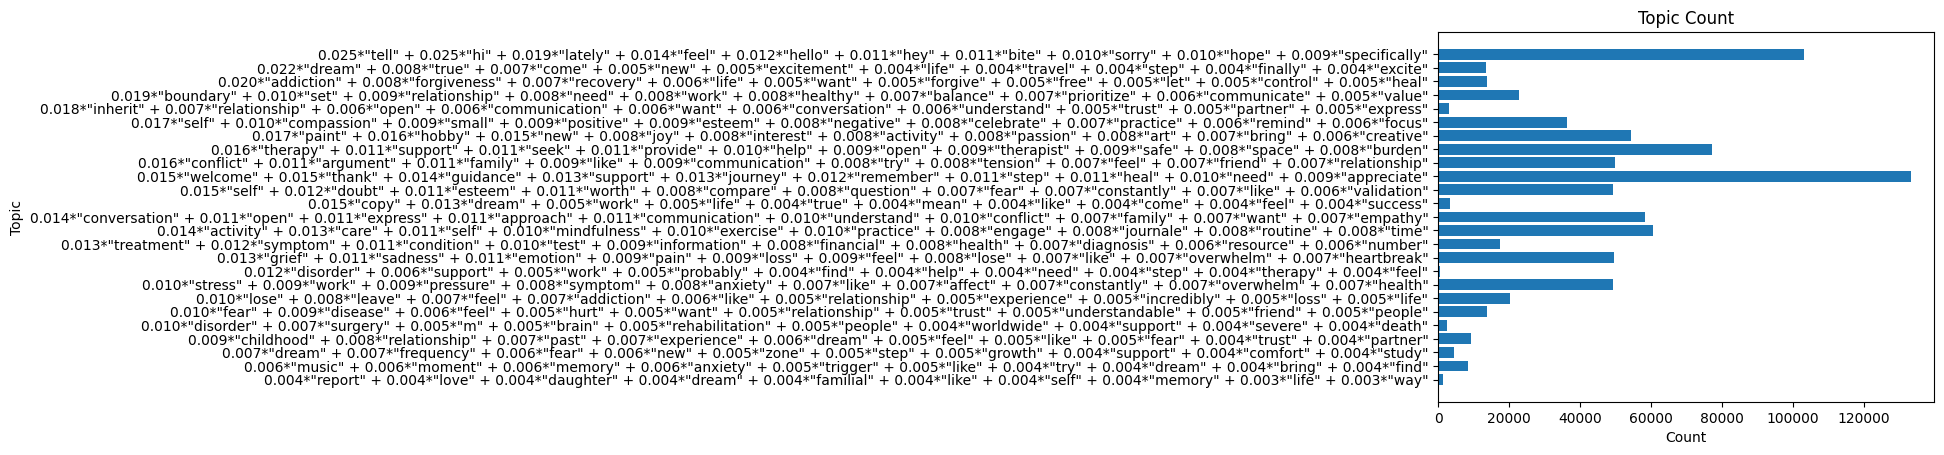

In [175]:
topic_count = processed_data.groupby(["Topic"]).agg({"Data" : "count"}).reset_index()
plt.barh(topic_count["Topic"], topic_count["Data"])
plt.ylabel("Topic")
plt.xlabel("Count")
plt.title("Topic Count")
plt.show()

In [3]:
dataset = pd.read_csv("intent_data.csv")

In [4]:
dataset

,Questions,Answers,Intent
0,It just feels like everything is falling apart...,It sounds like you're placing a lot of blame o...,Stress
1,"We've tried talking, but it always ends up esc...",It can be incredibly challenging when communic...,Stress
2,I haven't really thought about it. To be hones...,It's understandable that you may feel skeptica...,Stress
3,I guess it couldn't hurt to give it a try. But...,It's natural to have doubts and fears when fac...,Anxiety
4,I never thought that therapy could be helpful ...,"Absolutely, Charlie. Therapy is not just about...",Therapeutic Techniques
...,...,...,...
855670,I haven't thought about that yet. I'll look in...,"That's a great step, Charlie. Consulting a fin...",Stress
855671,"Thank you, Alex, for reminding me of that. It'...","It's understandable, Charlie. It's common for ...",Therapeutic Techniques
855672,"Well, I've been experiencing some physical sym...",It's important to note the mind and body conne...,Anxiety
855673,"I've been having frequent headaches, difficult...",I can imagine how distressing these physical s...,Anxiety


In [5]:
def modify(data):
    if data == "Phobias" or data == "Sleep Disorders" or data == "Obsessive-Compulsive Disorder (OCD)" or data == "Eating Disorders" or data == "Panic Attacks":
        return "Others"
    else:
        return data

In [6]:
dataset["New Intent"] = dataset["Intent"].apply(modify)

In [7]:
avg_price = dataset.groupby(["New Intent"]).agg({"Questions" : "count"}).reset_index().sort_values(by=["Questions"], ascending=False)
fig = px.bar(avg_price, x='New Intent', y='Questions',text_auto='.2s', labels={"New Intent" : "Intent", "Questions" : "Count"})
fig.update_layout(title_text='Intent Counts', title_x=0.5, width=1000, height=650)
fig.show()

In [14]:
avg_price = dataset.groupby(["Intent"]).agg({"Questions" : "count"}).reset_index().sort_values(by=["Questions"], ascending=False)
fig = px.bar(avg_price, x='Intent', y='Questions',text_auto='.2s', labels={"Intent" : "Intent", "Questions" : "Count"})
fig.update_layout(title_text='Intent Counts', title_x=0.5, width=1000, height=650)
fig.show()